### ICN Invasive Electrophysiology tutorial 

The tutorial requires the following installed packages: 
 - numpy
 - mne 
 - matplotlib
 
For installing type 

```python
import sys
!{sys.executable} -m pip install mne
```

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import mne
import scipy.io as spio
mne.__version__

'0.21.2'

First let's choose a folder where we will create some files: 

In [3]:
root = r'C:\Users\ICN_admin\Documents\MATLAB_Electrophysiology_Import\Python'
root = r'C:\Users\Jonathan\Documents\DATA\PROJECT_Tutorial\notebook'

#### Data generation

Now let's create some fake data first. We will stick along with the MNE Raw Array tutorial https://mne.tools/0.11/auto_tutorials/plot_creating_data_structures.html. 
Using the MNE RawArray initialization we provide an info dictionary that can contain various aspects of the data. 
Here we specify the
 - channel names 
 - channel types 
 - sampling frequency 

In [4]:
# Generate some random data
data = np.random.randn(5, 10000)

# Initialize an info structure
info = mne.create_info(
    ch_names=['ECOG_1_L_SM_AT', 'ECOG_2_L_SM_AT', 'ECOG_3_L_SM_AT', 'ECOG_4_L_SM_AT', 'EMG_1_R_BR_TM'],
    ch_types=['ecog', 'ecog', 'ecog', 'ecog', 'emg'],
    sfreq=1000
)

custom_raw = mne.io.RawArray(data, info)
print(custom_raw)

Creating RawArray with float64 data, n_channels=5, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
<RawArray | 5 x 10000 (10.0 s), ~405 kB, data loaded>


Based on this data we can plot the data stream: 
For inline plotting:  
```
%matplotlib inline 
```
For interactive window: 
```
%matplotlib qt
```


In [5]:
%matplotlib inline

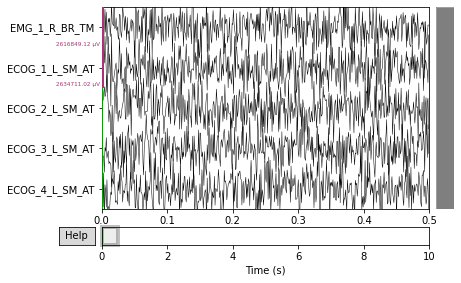

In [7]:
fig = custom_raw.plot(duration=0.5, bgcolor="w", 
                scalings="auto")

#Jonathan: for me this plot did not really show up as nicely as expected, but I don't know why that is. The figure is super tiny.

### Read fieldtrip data

Now we will demonstrate the feasibility to read fieldtrip generate .mat files in python.
Scipy supports this using an io function, but accessing the struct keys is not straightforward. Luckily previous wrapper functions have proposed to convert every struct element into a respective dictionary 

https://stackoverflow.com/questions/7008608/scipy-io-loadmat-nested-structures-i-e-dictionaries

In [8]:
# from stackoverflow answer above 

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

In [24]:
#Question: where is this data to be found?
path_fieldtrip = r'C:\Users\ICN_admin\Documents\MATLAB_Electrophysiology_Import\fieldtrip_sub-001_MedOff_StimOff_16-Dec-1985.mat'

In [25]:
ft = loadmat(path_fieldtrip)

In [26]:
ft

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Sun Feb 14 12:50:37 2021',
 '__version__': '1.0',
 '__globals__': [],
 'data': {'trial': array([[  4.7727355 , -24.00878152, -24.09943197, ...,   1.81095891,
           29.26696365,  -8.00461687],
         [-10.10217801, -54.39225965, -61.37930406, ...,   8.24986502,
           -0.43415379,  -2.24514335],
         [ 26.29846896, -37.99431376, -13.68528982, ...,  53.72061546,
           -9.53969738, -26.30481759],
         ...,
         [-26.60669239, -50.88489575, -80.07684686, ...,   5.94662928,
            6.20339614, -26.35325314],
         [-92.40098246,  55.11030908, 139.01050399, ...,  13.79530378,
           63.79531904,  19.90323634],
         [ -8.29825891,  19.55282177,  37.70376312, ..., -50.46715039,
          -11.97880591,   1.61190942]]),
  'time': array([0.00000000e+00, 3.57164117e-03, 7.14328234e-03, ...,
         5.99928567e+01, 5.99964284e+01, 6.00000000e+01]),
  'label': array(['LFP_0_R_STN_U', 'LFP

great! now we can simply access the fieldtrip file as a dictionary

In [44]:
ft["data"]["hdr"]["chantype"]

array(['SEEG', 'SEEG', 'SEEG', 'SEEG', 'SEEG', 'SEEG', 'SEEG', 'ECOG',
       'ECOG', 'ECOG', 'ECOG', 'EEG', 'EEG', 'EMG', 'EMG'], dtype=object)

So let's initialize the MNE RawArray as above and call some handy functions for basic electrophysiological signal processing

In [52]:
ft["data"]["trial"].shape

(15, 16800)

In [56]:
ft["data"]["hdr"]["chantype"]

array(['SEEG', 'SEEG', 'SEEG', 'SEEG', 'SEEG', 'SEEG', 'SEEG', 'ECOG',
       'ECOG', 'ECOG', 'ECOG', 'EEG', 'EEG', 'EMG', 'EMG'], dtype=object)

Note that there is a difference in the supported Fieldtrip data types, so we have to convert them to lowercase 

In [65]:
info = mne.create_info(
    ch_names=list(ft["data"]["label"]),
    ch_types=list(map(lambda x:x.lower(), ft["data"]["hdr"]["chantype"])),
    sfreq=ft["data"]["hdr"]["Fs"]
)

custom_raw = mne.io.RawArray(ft["data"]["trial"], info)

Creating RawArray with float64 data, n_channels=15, n_times=16800
    Range : 0 ... 16799 =      0.000 ...    59.996 secs
Ready.


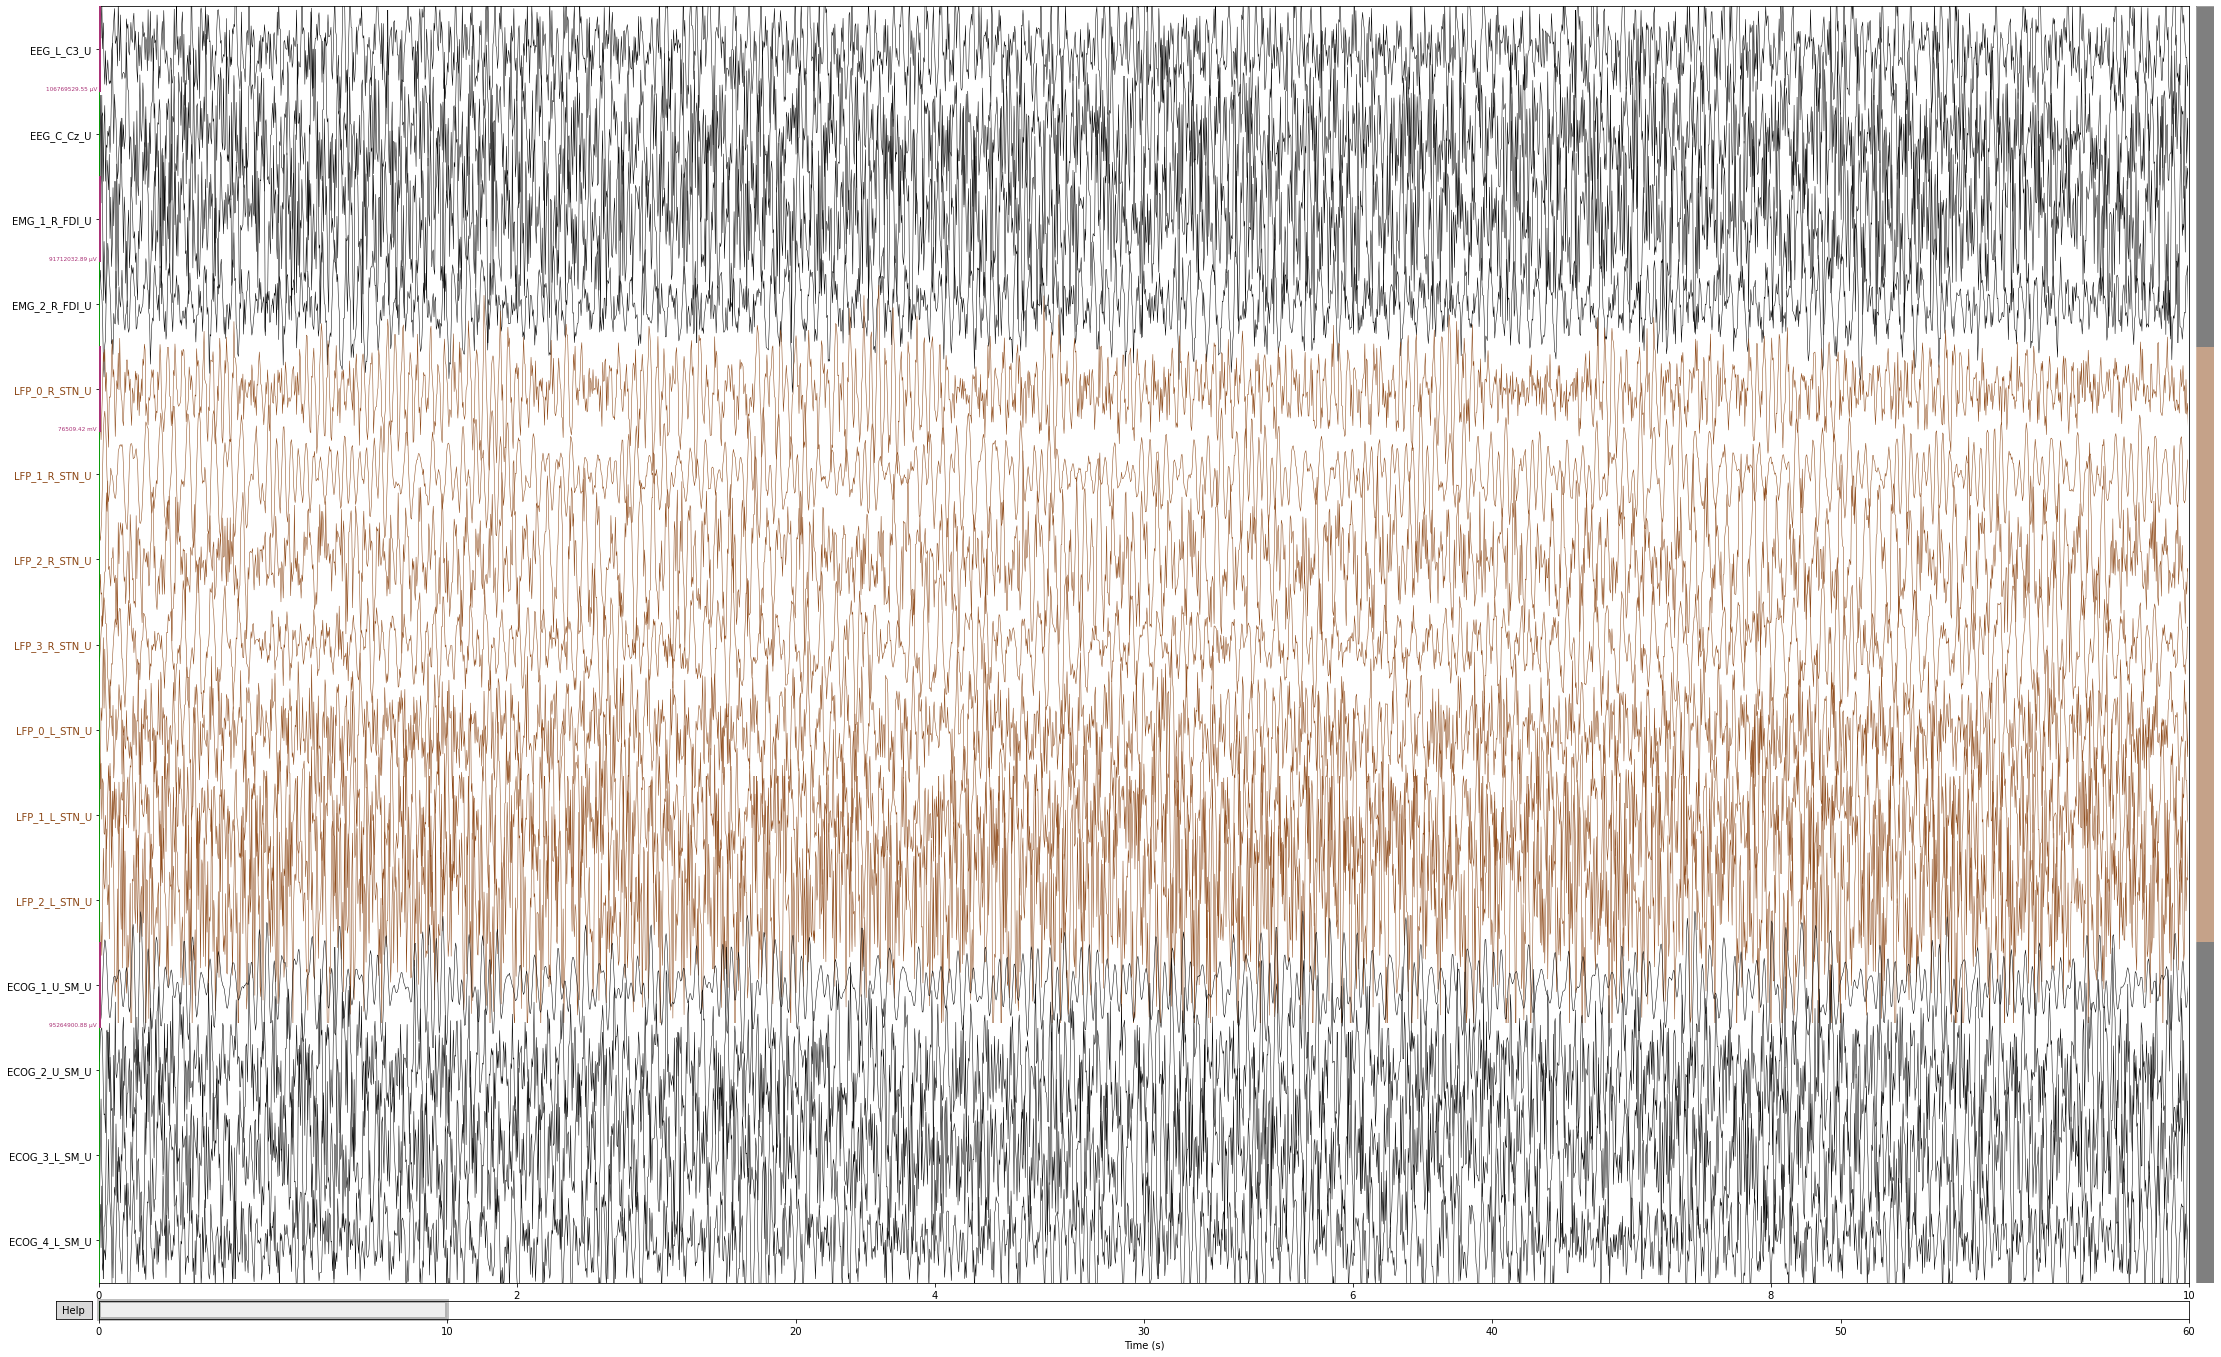

In [70]:
custom_raw.plot(scalings="auto")
plt.show()

MNE offers many functionalities, we will here discuss rereferencing. For depth LFP channels bipolar referencing is commonly used (mne.set_bipolar_reference). For ECoG or EEG Common Average Referencing (CAR) is recommended. 

In [109]:
good_inds = mne.pick_types(custom_raw.info, ecog=True)
goodchs = [custom_raw.ch_names[g] for g in good_inds]
custom_raw.set_eeg_reference(ref_channels=goodchs)

EEG channel type selected for re-referencing
Applying a custom EEG reference.


<RawArray | 15 x 16800 (60.0 s), ~2.0 MB, data loaded>

In [112]:
custom_raw.info

<Info | 8 non-empty values
 bads: []
 ch_names: LFP_0_R_STN_U, LFP_1_R_STN_U, LFP_2_R_STN_U, LFP_3_R_STN_U, ...
 chs: 7 SEEG, 4 ECOG, 2 EEG, 2 EMG
 custom_ref_applied: True
 highpass: 0.0 Hz
 lowpass: 140.0 Hz
 meas_date: unspecified
 nchan: 15
 projs: []
 sfreq: 280.0 Hz
>

Now let's explore some functions of the MNE RawArray. First plot a PSD of the average channel types: 

Effective window size : 7.314 (s)
Effective window size : 7.314 (s)
Effective window size : 7.314 (s)


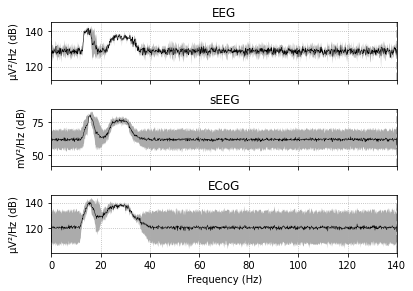

In [80]:
custom_raw.plot_psd(average=True)
plt.show()

Next plot a time frequency plot. Note, MNE only supports time frequency plots for data with specified events (e.g. button press). Therefore we will use here the scipy signal function: 

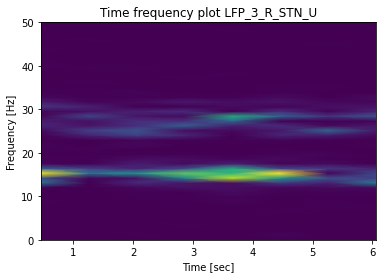

In [107]:
from scipy import signal
f, t, Sxx = signal.spectrogram(custom_raw.get_data()[3,:2000], custom_raw.info["sfreq"])
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylim(0, 50)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title("Time frequency plot "+str(custom_raw.ch_names[3]))
plt.show()